In [1]:
! wget <https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt>
! wget <https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt>
! mv ratings_*.txt ~/aiffel/sentiment_classification

명령 구문이 올바르지 않습니다.
명령 구문이 올바르지 않습니다.
'mv'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('./ratings_train.txt')
test_data = pd.read_table('./ratings_test.txt')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
from eunjeon import Mecab
# 은전한닢에서 Mecab import
tokenizer = Mecab()

# 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    X_train = []
    
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # .morphs 형태소 단위(체언, 조사, 어근, 어미) 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # .morphs 형태소 단위(체언, 조사, 어근, 어미) 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 1902 이 출력됩니다. 
print(index_to_word[1902])     # 'the' 가 출력됩니다.0

<BOS>
1902
the


In [6]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.972842084785936
문장길이 최대 :  116
문장길이 표준편차 :  12.843357707480491
pad_sequences maxlen :  41
전체 문장의 0.9342732378070944%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
# X_train = np.array(X_train)
# X_test = np.array(X_test)

In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post
                                                        maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)
print(X_train.shape)

(146182, 41)


In [10]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  32, 600,   4,   4,  39, 229,  20,
        33, 745])

In [11]:
vocab_size = len(word_to_index)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# embedding = tf.keras.layers.Embedding(input_dim=vocab_size, 
#                                       output_dim=word_vector_dim, mask_zero=True)

# X_train = embedding(X_train)

In [12]:
X_train

array([[   0,    0,    0, ...,   20,   33,  745],
       [   0,    0,    0, ...,   15,   44,  395],
       [   0,    0,    0, ...,    9,  276,  200],
       ...,
       [   0,    0,    0, ..., 2720,    6,   18],
       [   0,    0,    0, ...,   60,  394, 8573],
       [   0,    0,    0, ...,   89, 2748,    5]])

In [26]:
# [[YOUR CODE]]
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim))
# model.add(Dropout(0.5))
# model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
# model.add(MaxPooling1D(pool_size=4))
model.add(keras.layers.LSTM(8))   
model.add(keras.layers.Dense(8, activation='relu'))  
model.add(keras.layers.Dense(1, activation='sigmoid'))  
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_test, y_test),
                    verbose=1,
                   )
# callbacks=[early_stopping_callback, checkpointer]

Epoch 1/20
286/286 [==============================] - 25s 78ms/step - loss: 0.1504 - accuracy: 0.9460 - val_loss: 0.4502 - val_accuracy: 0.8463
Epoch 2/20
286/286 [==============================] - 21s 75ms/step - loss: 0.1347 - accuracy: 0.9522 - val_loss: 0.4680 - val_accuracy: 0.8431
Epoch 3/20
286/286 [==============================] - 22s 76ms/step - loss: 0.1247 - accuracy: 0.9566 - val_loss: 0.4947 - val_accuracy: 0.8433
Epoch 4/20
286/286 [==============================] - 21s 74ms/step - loss: 0.1163 - accuracy: 0.9605 - val_loss: 0.5113 - val_accuracy: 0.8403
Epoch 5/20
286/286 [==============================] - 21s 75ms/step - loss: 0.1099 - accuracy: 0.9614 - val_loss: 0.5331 - val_accuracy: 0.8371
Epoch 6/20
286/286 [==============================] - 21s 75ms/step - loss: 0.1020 - accuracy: 0.9662 - val_loss: 0.5550 - val_accuracy: 0.8379
Epoch 7/20
286/286 [==============================] - 22s 77ms/step - loss: 0.0952 - accuracy: 0.9681 - val_loss: 0.5888 - val_accuracy:

In [29]:
# 테스트 정확도 출력
print('\n Test Accuracy: %.4f' % (model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 6s 4ms/step - loss: 0.8657 - accuracy: 0.8305

 Test Accuracy: 0.8305


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


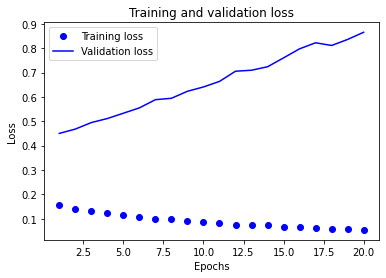

In [30]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')

# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

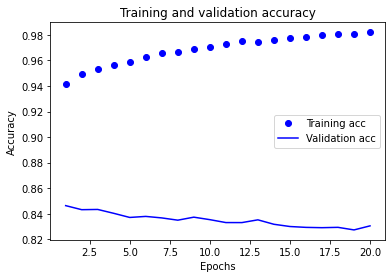

In [31]:
plt.clf()   # 그림을 초기화합니다
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
import gensim

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 200)


TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'